In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
print("Environment ready")


Environment ready


Project Summary:

This project predicts customer churn using the Telco Customer Churn dataset and Logistic Regression. It includes data cleaning, one-hot encoding, model evaluation using confusion matrix and ROC-AUC, and threshold tuning to improve churn detection. Key churn drivers were identified using model coefficients to support actionable retention strategies.

In [2]:
import pandas as pd

df = pd.read_csv("Telco-Customer-Churn.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Check missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
# Check target variable distribution
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [6]:
# Convert TotalCharges from object to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many NaNs were created
df['TotalCharges'].isna().sum()

11

In [7]:
# Check rows where TotalCharges is missing
df[df['TotalCharges'].isna()][['tenure', 'MonthlyCharges', 'TotalCharges']].head(15)

,tenure,MonthlyCharges,TotalCharges
488,0,52.55,NaN
753,0,20.25,NaN
936,0,80.85,NaN
1082,0,25.75,NaN
1340,0,56.05,NaN
3331,0,19.85,NaN
3826,0,25.35,NaN
4380,0,20.00,NaN
5218,0,19.70,NaN
6670,0,73.35,NaN


In [8]:
df = df.dropna(subset=['TotalCharges'])
df.shape

(7032, 21)

In [9]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['Churn'].value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [10]:
df = df.drop('customerID', axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [11]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.shape

(7032, 31)

In [12]:
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X.shape, y.shape

((7032, 30), (7032,))

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((5625, 30), (1407, 30))

In [14]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    class_weight='balanced'
)

log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.74      1407



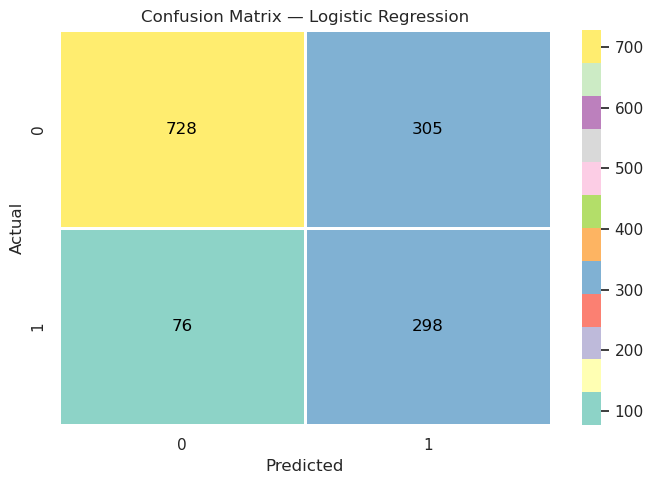

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,5))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Set3",
    annot_kws={"color": "black"},
    cbar=True,
    linewidths=1,
    linecolor="white"
)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

The model correctly predicts most non-churn customers (728) and identifies many churn customers (298). However, it still produces some false churn alerts (305) and misses a few churners (76), so there’s room to improve precision for churn.

In [16]:
import pandas as pd

# Create coefficient table
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": log_reg.coef_[0]
})

# Rank by absolute impact
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

# Show top 15 most important features
coef_df.head(15)

,Feature,Coefficient,Abs_Coefficient
25,Contract_Two year,-1.402038,1.402038
24,Contract_One year,-0.765921,0.765921
8,MultipleLines_No phone service,0.541929,0.541929
13,OnlineSecurity_Yes,-0.501593,0.501593
19,TechSupport_Yes,-0.466935,0.466935
28,PaymentMethod_Electronic check,0.404337,0.404337
10,InternetService_Fiber optic,0.391710,0.391710
7,PhoneService_Yes,-0.361364,0.361364
26,PaperlessBilling_Yes,0.264522,0.264522
15,OnlineBackup_Yes,-0.255692,0.255692


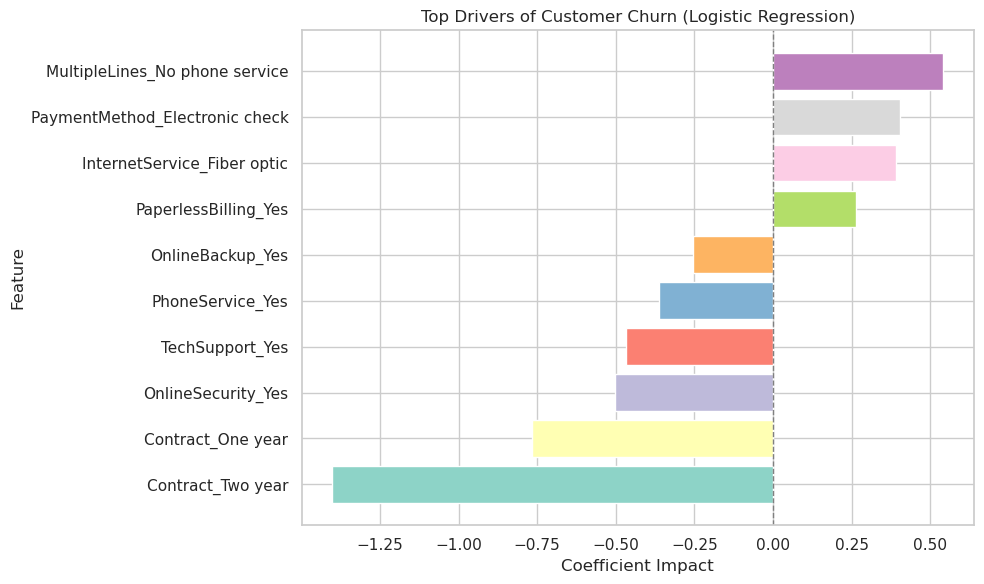

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

top10 = coef_df.head(10).sort_values("Coefficient")

set3_colors = sns.color_palette("Set3", n_colors=len(top10))

plt.figure(figsize=(10,6))
plt.barh(top10["Feature"], top10["Coefficient"], color=set3_colors)

plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Top Drivers of Customer Churn (Logistic Regression)")
plt.xlabel("Coefficient Impact")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()


The feature importance plot highlights the strongest drivers of churn based on Logistic Regression coefficients. Long-term contracts (one-year and two-year) significantly reduce churn likelihood, while electronic check payments and fiber optic internet are associated with higher churn risk. These insights can support targeted retention strategies such as contract upgrades and customer support improvements for high-risk segments.

ROC-AUC Score: 0.836


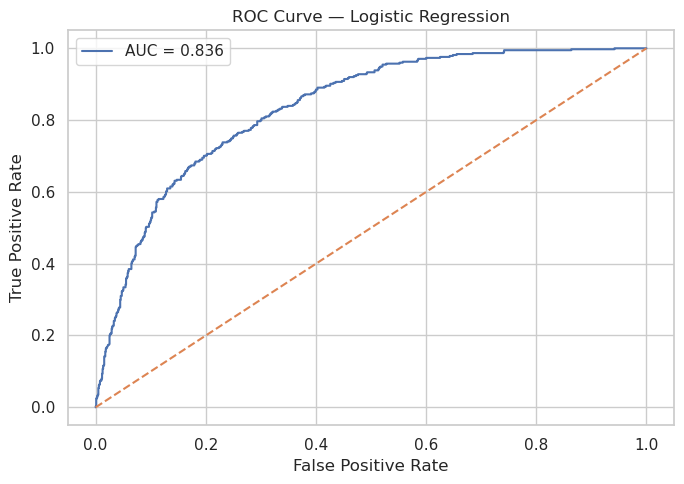

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_prob = log_reg.predict_proba(X_test)[:, 1]  # probability of churn (class 1)

auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", round(auc, 3))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve — Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

The ROC curve shows the model’s ability to distinguish between churn and non-churn customers across decision thresholds. With an AUC of 0.836, the model demonstrates strong discriminatory power, making it effective for ranking customers by churn risk and supporting targeted retention strategies.

Average Precision (AP): 0.623


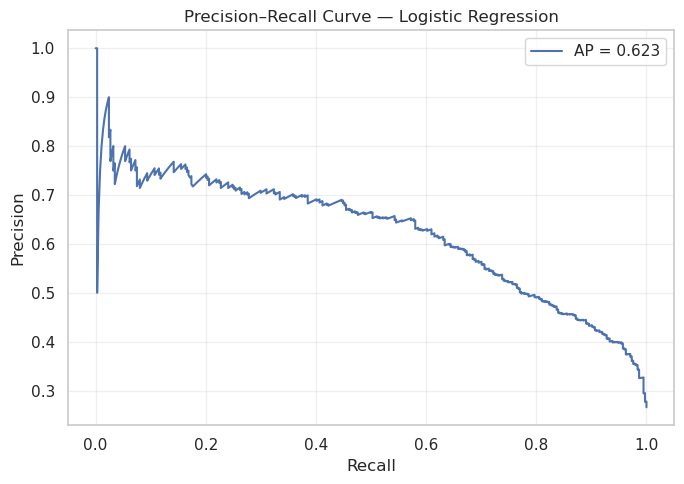

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Probabilities for class 1 (Churn)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Precision-Recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Average Precision Score
ap = average_precision_score(y_test, y_prob)
print("Average Precision (AP):", round(ap, 3))

# Plot PR Curve
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.title("Precision–Recall Curve — Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Average Precision (AP) = 0.623, shows the model is doing a solid job identifying churn customers despite class imbalance. The curve also shows a clear trade-off: as recall increases, precision drops, meaning we catch more churners but also flag more false positives

In [20]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

# churn probabilities
y_prob = log_reg.predict_proba(X_test)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)

best_thresh = 0
best_f1 = 0

for t in thresholds:
    y_pred_thresh = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print("Best Threshold:", best_thresh)
print("Best F1 Score:", round(best_f1, 3))

# show precision & recall for the best threshold
y_best = (y_prob >= best_thresh).astype(int)
print("Precision:", round(precision_score(y_test, y_best), 3))
print("Recall:", round(recall_score(y_test, y_best), 3))

Best Threshold: 0.6500000000000001
Best F1 Score: 0.623
Precision: 0.576
Recall: 0.679


Threshold tuning improved churn detection by optimizing the trade-off between precision and recall. At the best threshold (0.65), the model achieved an F1-score of 0.623 with 0.576 precision and 0.679 recall, making it more effective for identifying churn customers while controlling false positives

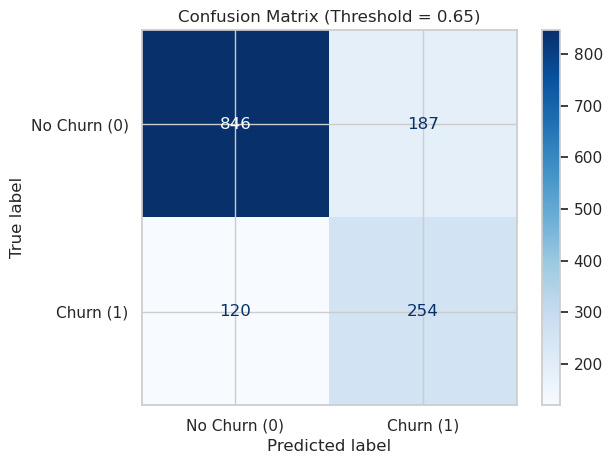

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use tuned threshold
best_thresh = 0.65
y_pred_best = (y_prob >= best_thresh).astype(int)

cm_best = confusion_matrix(y_test, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=["No Churn (0)", "Churn (1)"])
disp.plot(cmap="Blues")

plt.title(f"Confusion Matrix (Threshold = {best_thresh})")
plt.tight_layout()
plt.show()

With a tuned threshold of 0.65, the model correctly identified 254 churn customers while keeping false alarms moderate (187 false positives). This threshold reduces unnecessary churn interventions while still capturing a strong portion of true churners (254 true positives vs 120 missed churn cases).

Business Recommendations (Actionable Insights):

Based on the logistic regression drivers and threshold-optimized churn predictions, customers with month-to-month contracts, fiber optic internet, and electronic check payment methods showed higher churn likelihood. Business actions should prioritize retention offers such as contract upgrades, service experience improvements for fiber users, and incentive-based payment method transitions to reduce churn risk proactively.

Conclusion:

This project built an end-to-end churn prediction workflow using Logistic Regression, including data cleaning, encoding, model evaluation, ROC analysis, and threshold tuning. The tuned threshold (0.65) improved the balance between catching churn customers and reducing false churn alerts. Overall, the model demonstrates strong predictive power (ROC-AUC ≈ 0.836) and provides interpretable churn drivers to support retention decision-making